C:\ProgramData\miniconda3\envs\cnmaps\Lib\site-packages\cartopy\mpl\geoaxes.py:1683: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_30084\2328012233.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


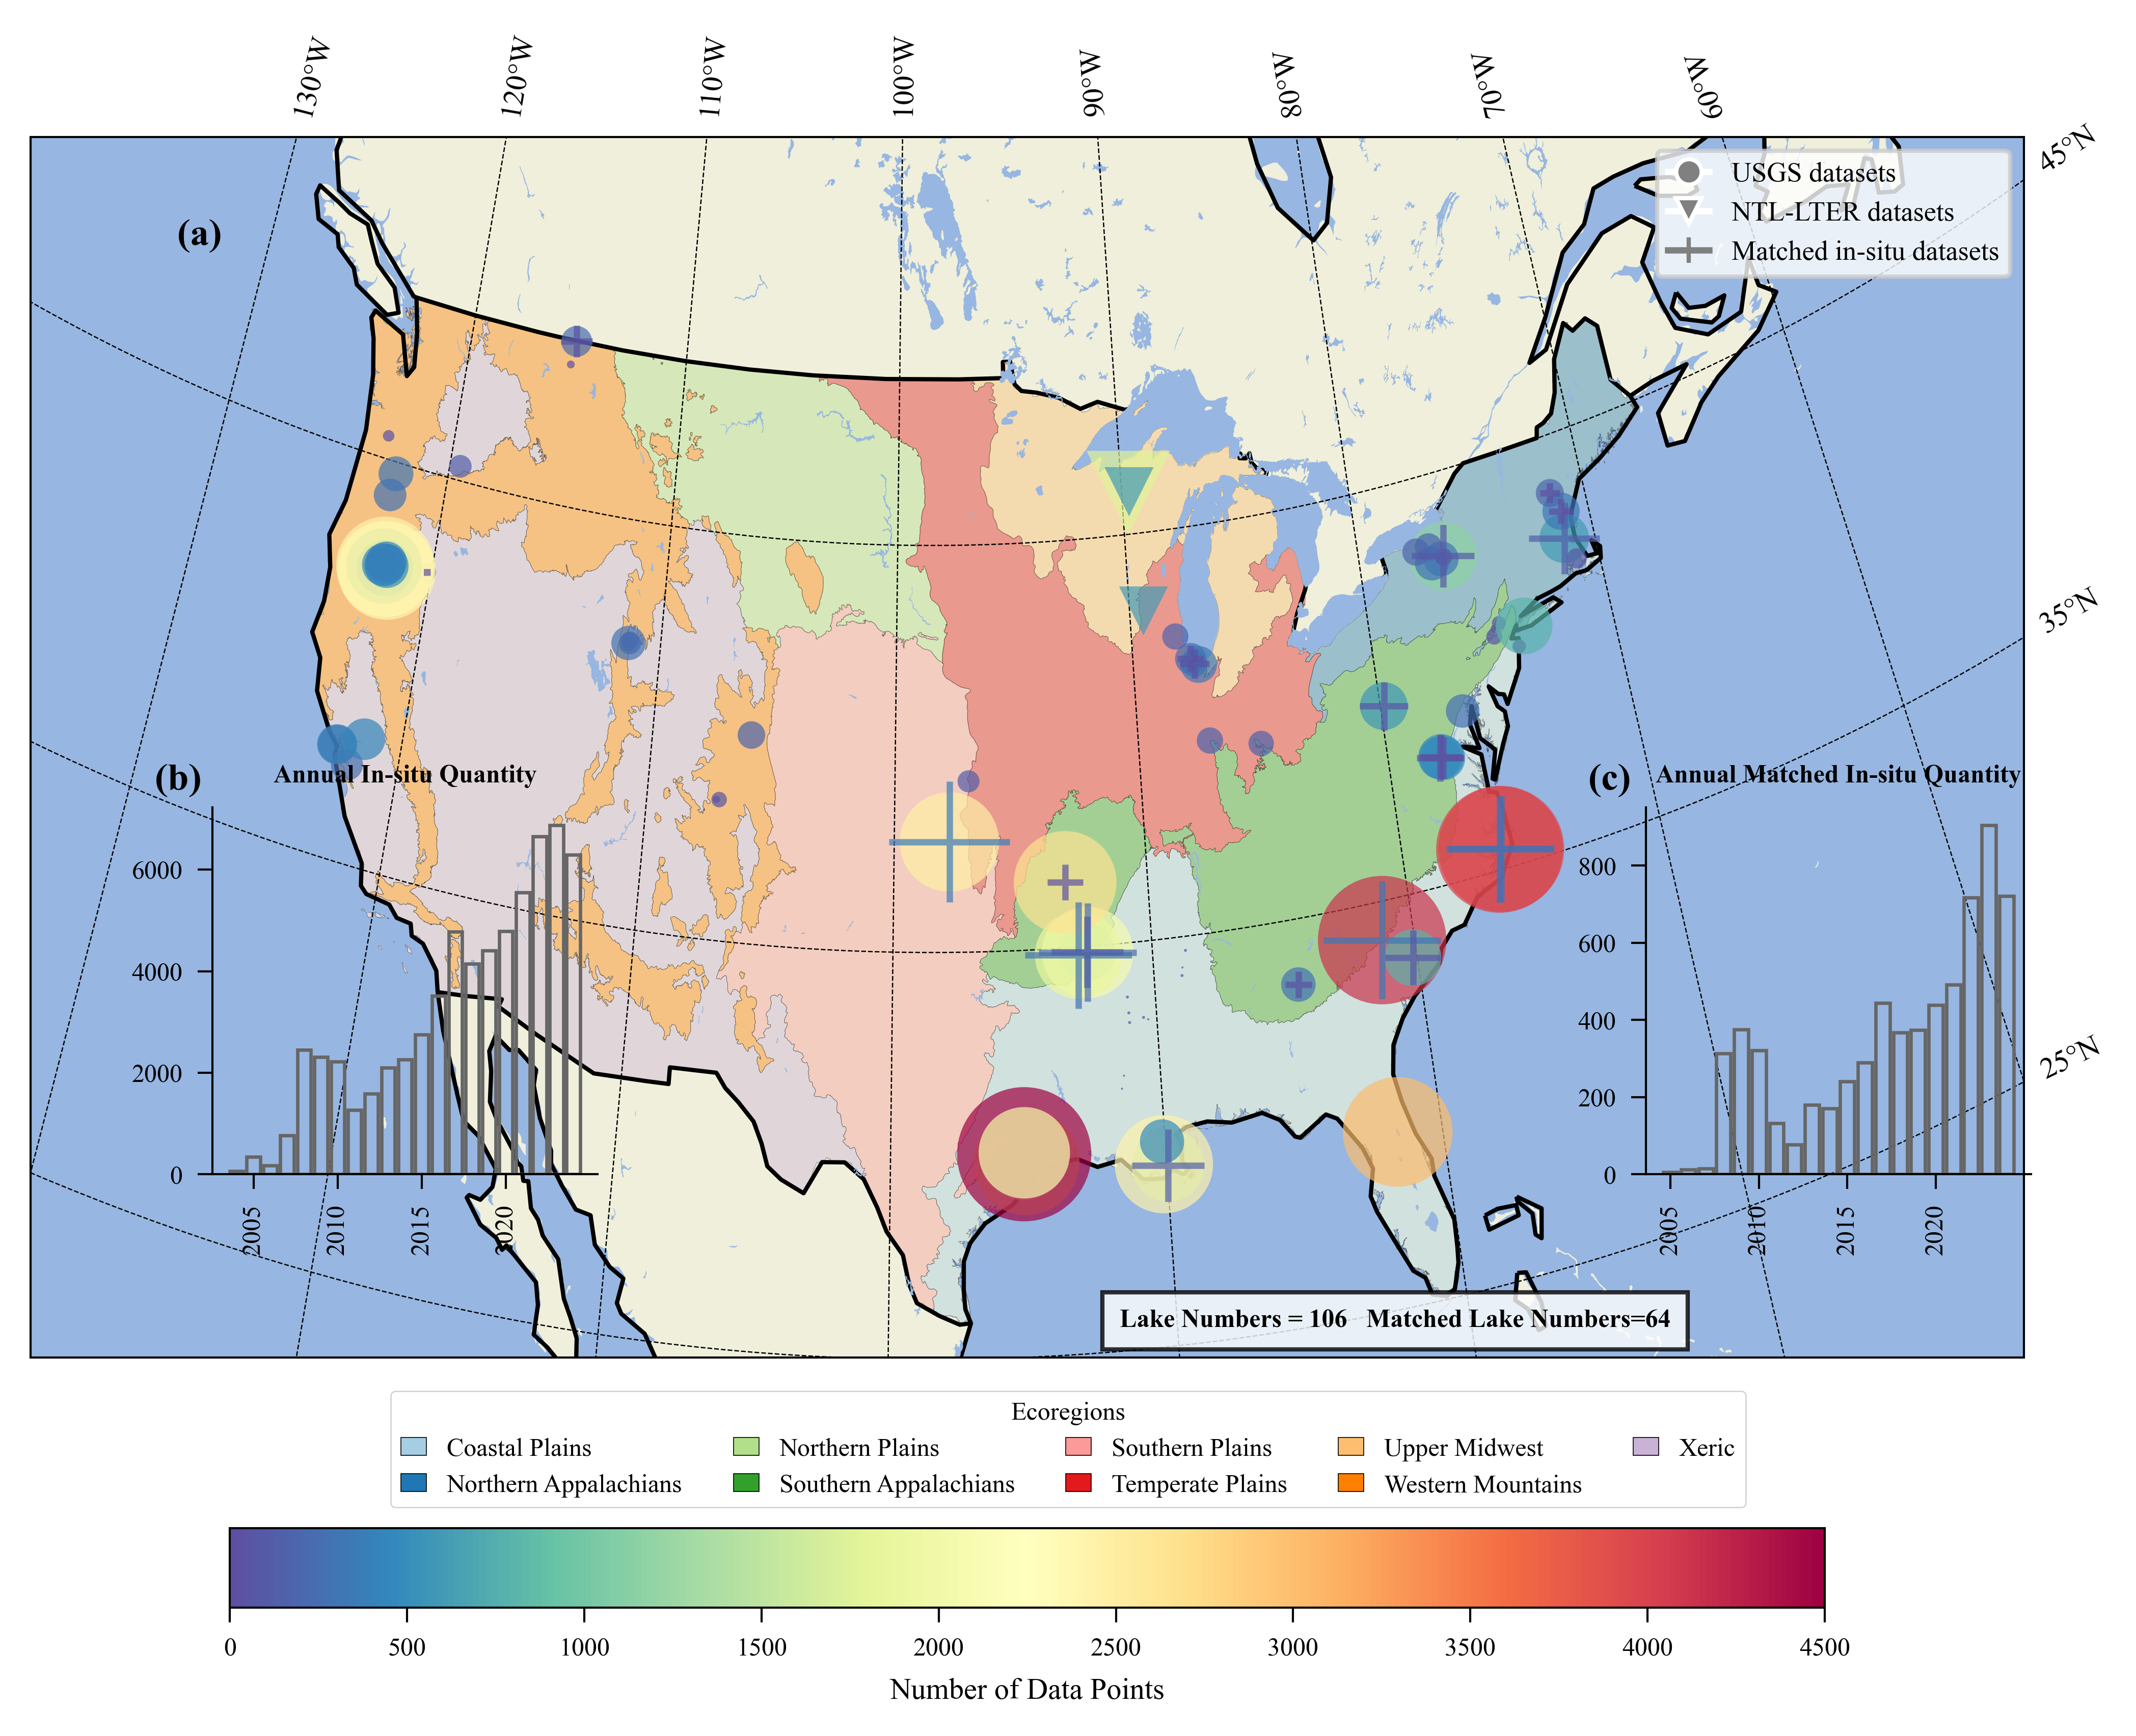

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

import geopandas as gpd
from matplotlib.patches import Patch
# 全局字体和风格设定
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 7,
    'axes.titlesize': 7,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'legend.title_fontsize': 6,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
})

# 数据加载 # 加载生态分区数据
df = pd.read_csv(r'F:\python_projection\daliy_pro\metabolizer\NA_WQ\site_no_vail_N.csv')
fd_match = pd.read_csv(r'F:\NPP_PROJECT\USA_IN-SITU_WQ\USGS\USGS_continue_DO_match_era5_v3_local\merged_result.csv', dtype={'site_no': str})

eco = gpd.read_file(r"F:\NPP_PROJECT\USA_IN-SITU_WQ\USGS\USGS_continue_DO_match_era5_v3_local\usa_hydro_lake_point_all_1km2\all_result_csv_analysis\Aggr_Ecoregions_2015.zip")
eco = eco.to_crs(epsg=4326)

years = np.array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
counts= np.array([64, 348, 174, 762, 2455, 2311, 2225, 1267, 1590, 2097, 2263, 2748, 3514, 4781, 4145, 4407, 4784, 5545, 6649, 6876, 6288])

# 年度统计
fd_match['year'] = pd.to_datetime(fd_match['time_column']).dt.year
site_counts = fd_match['site_no'].value_counts().reset_index()
site_counts.columns = ['site_no', 'count']
site_counts['site_no'] = site_counts['site_no'].astype(float).astype(int)
year_counts = fd_match['year'].value_counts().sort_index()
years_match = year_counts.index.tolist()
counts_match = year_counts.values.tolist()

# 空间匹配
unique_sites = df.drop_duplicates(subset='site_no')[['site_no', 'm_long', 'm_lat']]
df_match = pd.merge(site_counts, unique_sites, on='site_no')
df['days'] = df['Count']

# 归一化颜色和大小
min_count, max_count = df['days'].min(), df['days'].max()
norm_counts = (df['days'] - min_count) / (max_count - min_count)
norm_counts2 = (np.array([545, 1588, 548]) - min_count) / (max_count - min_count)
norm_counts3 = (df_match['count'] - min_count) / (max_count - min_count)

bubble_sizes = norm_counts * 1000
bubble_sizes2 = norm_counts2 * 1000
bubble_sizes3 = norm_counts3 * 10000

colors = plt.cm.Spectral_r(norm_counts)
colors2 = plt.cm.Spectral_r(norm_counts2)
colors3 = plt.cm.Spectral_r(norm_counts3)

# NTL 示例点
stations_df2 = pd.DataFrame({
    'Latitude': [43.099, 46.008, 46.029],
    'Longitude': [-89.405, -89.701, -89.665],
    'DataCount': [545, 1588, 548]
})

# 投影设置
projn = ccrs.LambertConformal(central_longitude=-98.5, central_latitude=39.5, standard_parallels=(20.0, 50.0))
fig = plt.figure(figsize=(7, 6), dpi=600, facecolor="w")
ax = fig.add_subplot(projection=projn)

# 地图要素
ax.add_feature(cfeature.COASTLINE.with_scale('110m'))
ax.add_feature(cfeature.BORDERS.with_scale('110m'))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES.with_scale('10m'))




# 设定颜色（NC风格）可自定义或用 colormap
ecoregion_colors = {
    'Coastal Plains': '#A6CEE3',
    'Northern Appalachians': '#1F78B4',
    'Northern Plains': '#B2DF8A',
    'Southern Appalachians': '#33A02C',
    'Southern Plains': '#FB9A99',
    'Temperate Plains': '#E31A1C',
    'Upper Midwest': '#FDBF6F',
    'Western Mountains': '#FF7F00',
    'Xeric': '#CAB2D6'
}

# 绘制生态分区
for name, group in eco.groupby("WSA9_NAME"):
    color = ecoregion_colors.get(name, "#cccccc")  # 默认灰色
    group.plot(ax=ax, facecolor=color, edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree(), zorder=1, alpha=0.4)

# 添加图例
ecoregion_legend_patches = [
    Patch(facecolor=color, edgecolor='black', linewidth=0.2, label=name)
    for name, color in ecoregion_colors.items()
]
# 在 colorbar 上方放置横向图例（分区）
from matplotlib.legend import Legend

legend_row_ax = fig.add_axes([0.2, 0.18, 0.6, 0.04])  # 控制位置 [left, bottom, width, height]
legend_row_ax.axis('off')  # 不显示坐标轴

# 构建横向图例
legend_row = Legend(legend_row_ax, handles=ecoregion_legend_patches, labels=[p.get_label() for p in ecoregion_legend_patches],
                    ncol=5, loc='center', frameon=True, fontsize=6, title='Ecoregions', title_fontsize=6, handlelength=1)
legend_row.get_frame().set_alpha(0.9)
legend_row.get_frame().set_linewidth(0.3)

legend_row_ax.add_artist(legend_row)

# 绘制站点
ax.scatter(df['m_long'], df['m_lat'], s=bubble_sizes, c=colors[:, :3], alpha=0.7, edgecolor='none',marker='o',
           transform=ccrs.PlateCarree(), zorder=5, label='USGS datasets')
ax.scatter(stations_df2['Longitude'], stations_df2['Latitude'], s=bubble_sizes2, c=colors2[:, :3], alpha=0.7,marker='v',
           edgecolor='none', transform=ccrs.PlateCarree(), zorder=5, label='NTL-LTER datasets')
ax.scatter(df_match['m_long'], df_match['m_lat'], s=bubble_sizes3, c=colors3[:, :3], alpha=0.7, edgecolor='none',marker='+',
           transform=ccrs.PlateCarree(), zorder=5, label='Matched in-situ datasets')

# 颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.Spectral_r, norm=mcolors.Normalize(vmin=0, vmax=4500))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8, label='Number of Data Points')

# 范围和标签
ax.set_extent([-130, -60, 25, 50], crs=ccrs.PlateCarree())
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='k', linestyle='dashed',
                   linewidth=0.3, y_inline=False, x_inline=False, xlocs=range(-130, -50, 10),
                   ylocs=range(25, 55, 10))

gls.left_labels = False
gls.bottom_labels = False
# 标签和标题
text = f"Lake Numbers = {106}   Matched Lake Numbers={64}"
ax.text(-92, 25.6, text, fontsize=6, fontweight='bold', transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.8))
# legend = plt.legend(loc='upper right', fontsize=8, handlelength=2, handletextpad=2,labelspacing=1.5,markerscale=0.5)
# for text in legend.get_texts():
#     text.set_weight('bold')
# 图例句柄：散点图图例（数据点）
# scatter_legend_elements = [
#     Patch(facecolor='gray', edgecolor='none', label='USGS datasets', marker='o'),
#     Patch(facecolor='gray', edgecolor='none', label='NTL-LTER datasets', marker='v'),
#     Patch(facecolor='gray', edgecolor='none', label='Matched in-situ datasets', marker='+'),
# ]

# 注意：不能用 Patch 来显示 marker 类型，需要使用 Line2D 来模拟
from matplotlib.lines import Line2D

scatter_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='USGS datasets',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='v', color='w', label='NTL-LTER datasets',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='+', color='gray', label='Matched in-situ datasets',
           markerfacecolor='gray', markersize=6),
]

# 添加图例（右上角）
ax.legend(handles=scatter_legend_elements, loc='upper right', fontsize=6.5, frameon=True,
          handlelength=1.5)

# Panel a 标注（主图）
ax.text(-134, 48, '(a)', transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold')

# Panel b：所有站点年度数量柱状图（透明风格）
inset_ax = fig.add_axes([0.1, 0.35, 0.18, 0.2])
bars = inset_ax.bar(years, counts, facecolor='none', edgecolor='#666666', linewidth=0.8)
inset_ax.set_title('Annual In-situ Quantity', fontsize=6, weight='bold')
inset_ax.set_xticks([y for y in years if y % 5 == 0])
inset_ax.set_xticklabels([y for y in years if y % 5 == 0], rotation=90)
inset_ax.set_facecolor('none')
# 只保留左和下边框
for spine in ['top', 'right']:
    inset_ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    inset_ax.spines[spine].set_linewidth(0.5)
# 添加 panel 标注 b
inset_ax.text(-0.15, 1.05, '(b)', transform=inset_ax.transAxes, fontsize=9, fontweight='bold')

# Panel c：匹配站点年度数量柱状图（透明风格）
inset_ax2 = fig.add_axes([0.77, 0.35, 0.18, 0.2])
bars = inset_ax2.bar(years_match, counts_match, facecolor='none', edgecolor='#666666', linewidth=0.8)
inset_ax2.set_title('Annual Matched In-situ Quantity', fontsize=6, weight='bold')
inset_ax2.set_xticks([y for y in years_match if y % 5 == 0])
inset_ax2.set_xticklabels([y for y in years_match if y % 5 == 0], rotation=90)
inset_ax2.set_facecolor('none')
for spine in ['top', 'right']:
    inset_ax2.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    inset_ax2.spines[spine].set_linewidth(0.5)
# 添加 panel 标注 c
inset_ax2.text(-0.15, 1.05, '(c)', transform=inset_ax2.transAxes, fontsize=9, fontweight='bold')


plt.tight_layout()
plt.savefig('FIG1_NC_f.pdf', dpi=600, bbox_inches='tight', transparent=True)
plt.savefig('FIG1_NC_f.jpg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()
